## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
row_num = df.shape[0]
print("Number of rows is: {}".format(row_num))

Number of rows is: 294478


c. The number of unique users in the dataset.

In [4]:
user_total = df.nunique()['user_id']
print("Number of unique users is : {}".format(user_total))

Number of unique users is : 290584


d. The proportion of users converted.

In [5]:
user_converted = df['converted'].mean()
print("Number of converted users is : {}".format(user_converted * 100))

Number of converted users is : 11.96591935560551


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# rows where treatment group user lands incorrectly on old_page 
mismatch_grp1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Times treatment group user lands incorrectly on old_page is {}".format(len(mismatch_grp1)))

# rows where control group user incorrectly lands on new_page
mismatch_grp2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Times control group user incorrectly lands on new_page is {}".format(len(mismatch_grp2)))

#  number of times the new_page and treatment don't line up is sum of above two values
print("Times new_page and treatment don't line up is {}".format(len(mismatch_grp1) + len(mismatch_grp2)))

Times treatment group user lands incorrectly on old_page is 1965
Times control group user incorrectly lands on new_page is 1928
Times new_page and treatment don't line up is 3893


f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# all columns have the total of 294478 entries, thus no missing value

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# drop rows for mismatched treatment groups
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
# drop rows for mismatched control groups
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
df.to_csv('ab_2.csv', index=False)
df2 = pd.read_csv('ab_2.csv')

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2_user_total = df2.nunique()['user_id']
print("Number of unique users in df2 is : {}".format(df2_user_total))

Number of unique users in df2 is : 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
sum(df2['user_id'].duplicated())
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1876    773192
2862    773192
Name: user_id, dtype: int64

In [15]:
# the repeated user_id is 773192

c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
time_dup = "2017-01-09 05:37:58.781806"
df2 = df2[df2.timestamp != time_dup]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2_grp = df.groupby('group')
df2_grp.describe()

converted                                                user_id  \
              count      mean       std  min  25%  50%  75%  max     count   
group                                                                        
control    145274.0  0.120386  0.325414  0.0  0.0  0.0  0.0  1.0  145274.0   
treatment  145311.0  0.118807  0.323563  0.0  0.0  0.0  0.0  1.0  145311.0   

                                                                      \
                    mean           std       min       25%       50%   
group                                                                  
control    788164.072594  91287.914601  630002.0  709279.5  788128.5   
treatment  787845.618446  91161.258854  630000.0  708746.5  787874.0   

                                
                 75%       max  
group                           
control    867208.25  945998.0  
treatment  866718.50  945999.0

c. Given that an individual was in the `treatment` group, what is the probability they converted?

d. What is the probability that an individual received the new page?

In [20]:
# number of individuals who got new page is same as those in treatment group
new_page_user = len(df2.query("group == 'treatment'"))

# calculate total number of users
users=df2.shape[0]

# thus, probability that an individual received the new page is new_user/users
print (new_page_user/users)

0.5000619442226688


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

### In the treatment group, the probability of an individual converted is 0.118807.
### In the control group, the probability of an individual converted is 0.120386.
### Thus, the conversion rate of control group who received old page, is higher by less than 0.2%. However, change aversion, test span durations and other potentially influencing factors are not accounted for. So, we cannot state with certainty that one page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Hypothesis
#### Null Hypo: 𝑝𝑜𝑙𝑑 >=  𝑝𝑛𝑒𝑤
#### Alternative Hypo: 𝑝𝑜𝑙𝑑 < 𝑝𝑛𝑒𝑤

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
print(p_new)

0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2['converted'].mean()
print(p_old)

0.119597087245


c. What is $n_{new}$?

In [23]:
n_new = len(df2.query("group == 'treatment'"))
print(n_new)

145310


d. What is $n_{old}$?

In [24]:
n_old = len(df.query("group == 'control'"))
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
print(len(new_page_converted))

145310


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
print(len(old_page_converted)) 

145274


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# since new_page_converted and old_page_converted have different sizes, we cannot directly compute p_diff
# since, differernce is only 36 values of thousands, we truncate the excess in new_page_converted
new_page_converted = new_page_converted[:145274]
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
print(p_diff) 

[ -6.88354420e-06   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Plot of 10000 simulated p_diffs')

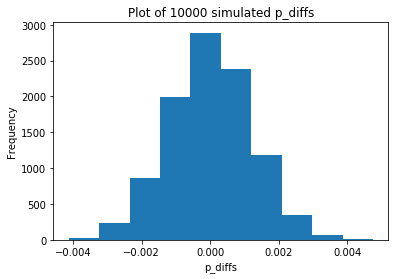

In [29]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10000 simulated p_diffs')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# compute difference from original dataset ab_data.csv
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
print (act_diff)

-0.00157905659769


In [31]:
p_diffs = np.array(p_diffs)
p_diffs

array([-0.00205313, -0.00013286,  0.00092031, ...,  0.00038338,
       -0.00024996, -0.00073164])

In [32]:
# proportion of p_diffs greater than the actual difference observed in ab_data.csv is computed as:
(act_diff < p_diffs).mean()

0.90539999999999998

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### We are computing the p-value. This is the probability of observing our statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. The more extreme in favor of the alternative portion of this statement determines the shading associated with your p-value. Here, we find that there is no conversion advantage with new pages. We conclude that null hypothesis is true as old and new pages perform almost similarly. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [35]:
from scipy.stats import norm
print("How significant our z-score is : {}".format(norm.cdf(z_score))) 
print("For single-sides test, assumed at 95% confidence level, what our critical value at 95% confidence is : {}".format(norm.ppf(1-(0.05))))


How significant our z-score is : 0.9050583127590245
For single-sides test, assumed at 95% confidence level, what our critical value at 95% confidence is : 1.6448536269514722


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'treatment']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:30:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

#### 0.190
#### Because the p-value in the Part II is for a one-sided test and this regression model is two sided test with the null hypothesis as not equal between 𝑝𝑜𝑙𝑑 and 𝑝𝑛𝑒𝑤

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### User age, gender, and other characteristics might influence the conversion rate.
#### However, when adding high correlations predictor variables, leading to unreliable and unstable estimates of regression coefficients (Multicollinearity) can affect the model. Every time we include a new predictor variable with no change in sample size we lose a degree of freedom. The result often is that previously significant predictor in the new regression is no long significant at the same probability of a Type 1 error (the significance level).

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
### Create the necessary dummy variables
df_new['intercept'] = 1
df_new[['CA','US']] = pd.get_dummies(df_new['country'])[['CA','US']]

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'CA']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        22:31:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

### Conclusions:
#### From the above results, adding new page does not show a significant impact on conversion rates. And countries have no significant impact, neither.
#### The company does not need to implement this new page as there is no conclusive evidence that it is better than the old page.

<a id='conclusions'></a>


In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0